> 해당 자료는 전북대학교 이영미 교수님 2023고급시계열분석 자료임

In [11]:
############## package
library(forecast) #ses
library(data.table)
library(ggplot2)
library(lmtest) #dwtest
library(TTR) #SMA
library(lubridate)
library(gridExtra)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘lubridate’


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




# 1

In [1]:
# 데이터 불러오기
z <- scan("mindex.txt")


$S_n^{(1)} = w \sum_{j=0}^{n-1} (1-w)^j Z_{n-j} + (1-w)^n S_0^{(1)}$

In [2]:
simple_exp_smoothing <- function(z,w,s0){
 Sn <- c()
 Sn[1] <- w*z[1] + (1-w)*s0
 for(k in 2:length(z)){
 Sn[k] <- w * z[k] + (1-w)*Sn[k-1]
 }
 return(Sn)
}


In [6]:
ses_0.6 <- simple_exp_smoothing(z,0.6,15)
ses_0.2 <- simple_exp_smoothing(z,0.2,15)

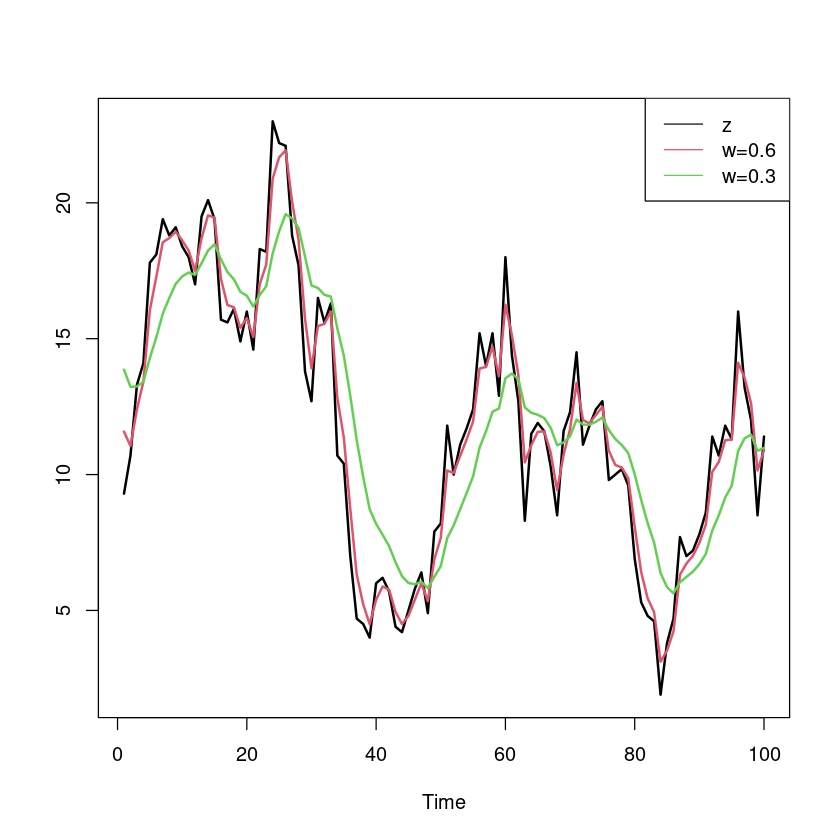

In [8]:
ts.plot(ts(z), ses_0.6, ses_0.2, col=1:3, lwd=2)
legend("topright", legend = c("z","w=0.6","w=0.3"), col=1:3, lty=1)

- W값이 클수록 원 데이터와 비슷하고, 평활 효과가 작아진다.

- W값이 작을수록 원데이터를 천천히 따라가고, 평활 효과가 커진다.

$\hat Z_{t-1}(1) = S_{t-1}^{(1)}$이므로

In [9]:
point <- c(2,3,99,100)
ses_0.6[point-1]
ses_0.2[point-1]


[1] 11.58000 11.05200 12.62628 10.15051

[1] 13.86000 13.22800 11.46773 10.87419

# 2

## (1)

In [15]:
z <- scan("female.txt")

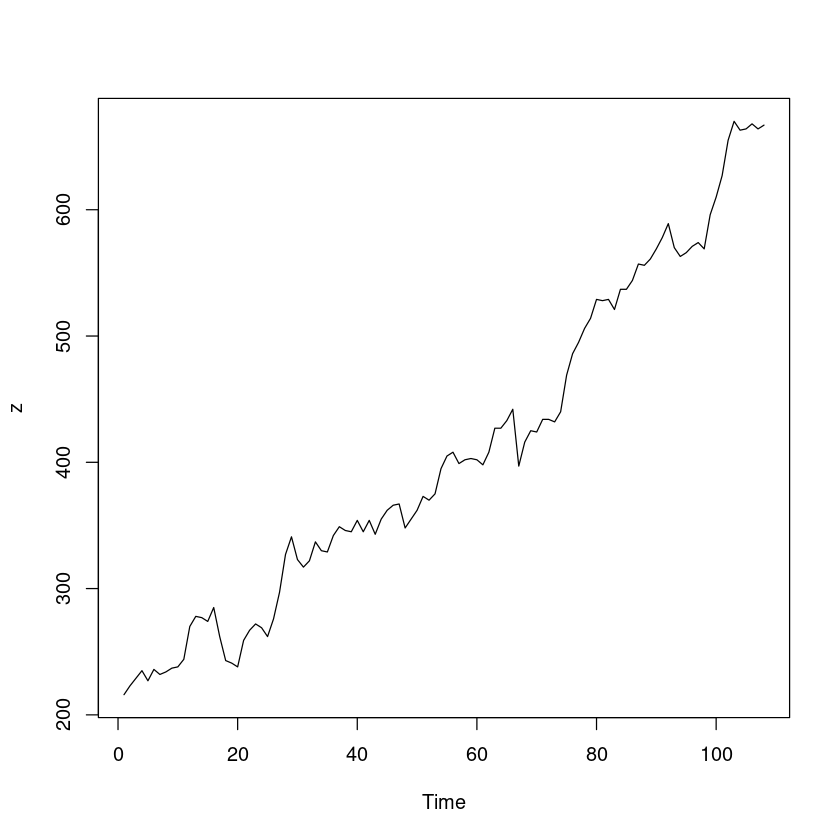

In [16]:
plot.ts(z)


- 추세가 있기 때문에 이중지수평활법을 사용한다.

In [17]:
female_smoothing <- HoltWinters(z, gamma = FALSE)
female_smoothing


Holt-Winters exponential smoothing with trend and without seasonal component.

Call:
HoltWinters(x = z, gamma = FALSE)

Smoothing parameters:
 alpha: 1
 beta : 0.01666631
 gamma: FALSE

Coefficients:
        [,1]
a 667.000000
b   5.145043

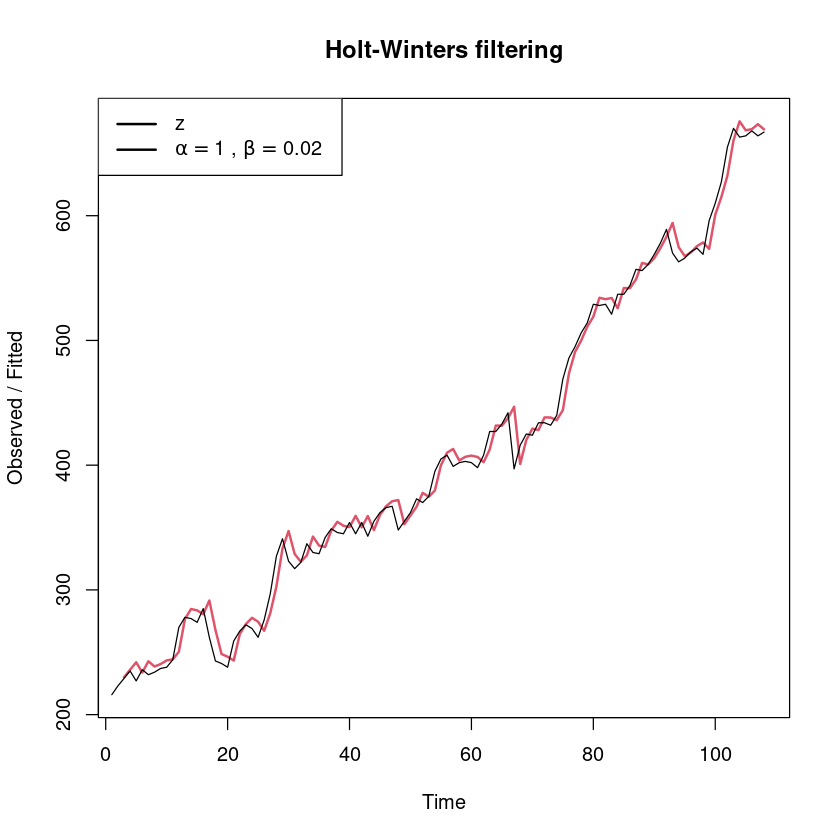

In [18]:
plot(female_smoothing, lwd=2)
legend("topleft", legend=c("z",expression(alpha == 1~","~beta==0.02)), lty=1, lwd=2)

`-` 예측오차 분석

In [19]:
head(female_smoothing$fitted)

,xhat,level,trend
3,230.0000,223,7.000000
4,235.9833,229,6.983334
5,241.9669,235,6.966945
6,233.7175,227,6.717501
7,242.7555,236,6.755542
8,238.5763,232,6.576287


- HoltWinters 함수를 사용하는 경우, 이중지수 평활값이 3번째부터 구해진다. 따라서
예측오차 역시 원데이터의 3번째 값부터 구할 수 있다. 

In [21]:
resid_female <- z[-(1:2)] - female_smoothing$fitted[,1] #또는
resid_female <- resid(female_smoothing) #같은 방법임

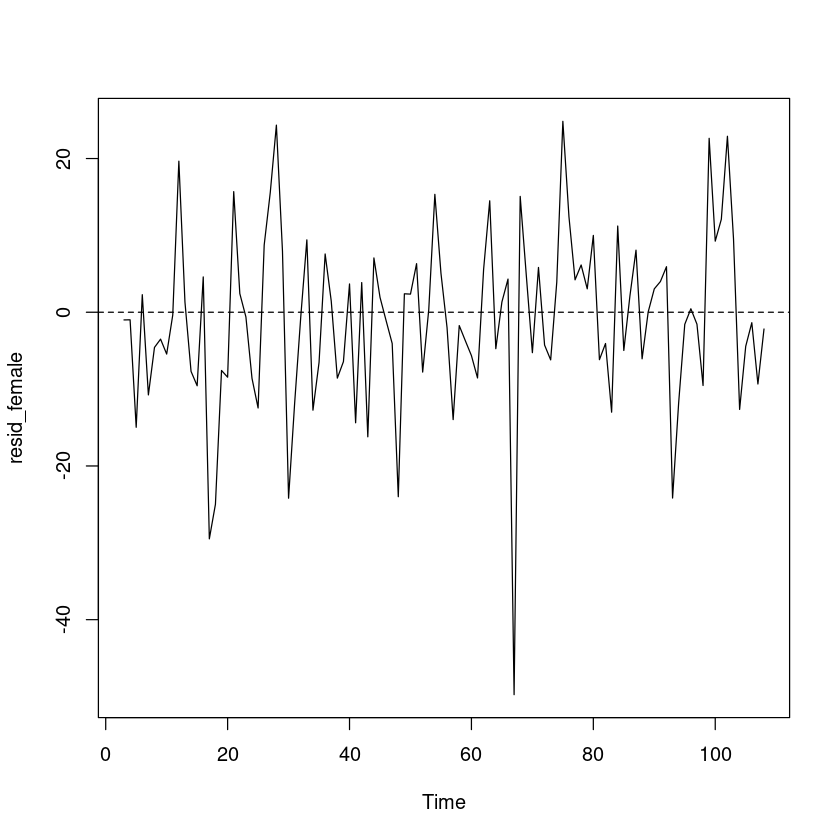

In [22]:
plot.ts(resid_female)
abline(h=0, lty=2)

- 예측오차의 경우 0을 중심으로 대칭이고, 이분산성은 없어 보인다.


In [23]:
t.test(resid_female)



	One Sample t-test

data:  resid_female
t = -0.93497, df = 105, p-value = 0.3519
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -3.276746  1.176749
sample estimates:
mean of x 
-1.049998 


- t-test 결과 예측오차의 평균은 0이라고 할 수 있다.

In [24]:
lmtest::dwtest(lm(resid_female~1), alternative="two.sided")


	Durbin-Watson test

data:  lm(resid_female ~ 1)
DW = 1.7861, p-value = 0.2662
alternative hypothesis: true autocorrelation is not 0


- DW test 결과 예측오차들 간의 자기 상관은 없는 것으로 보인다.

- 따라서 예측오차는 분석 결과 평활 결과는 적합하다고 할 수 있다.

## (2)

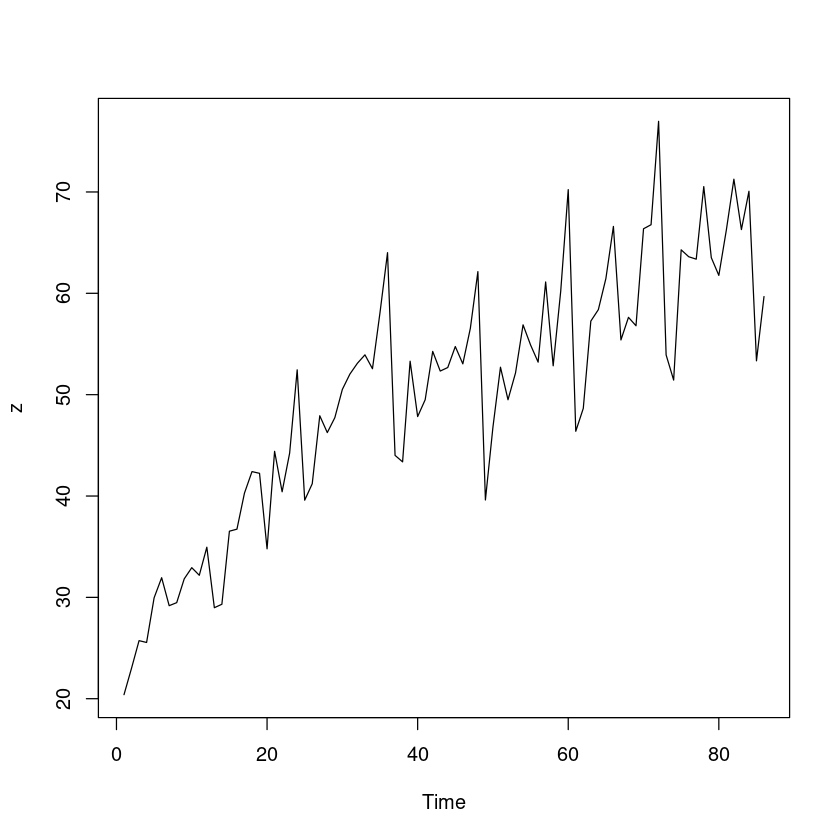

In [25]:
z <- scan("export.txt")
plot.ts(z)

- 지난 과제에 언급한대로 이 시계열에는 이분산성은 없다고 할 수 있다.

- 추세와 계절성분이 있으므로 계절주기가 12, 가법형 계절평활법을 사용하는 것이
적합하다.

- 계절평활을 하기 위해서는 데이터를 ts 객체로 변환해야 한다

In [26]:
z_ts <- ts(z, frequency=12)

In [27]:
export_smoothing <- HoltWinters(z_ts)
export_smoothing


Holt-Winters exponential smoothing with trend and additive seasonal component.

Call:
HoltWinters(x = z_ts)

Smoothing parameters:
 alpha: 0.3304767
 beta : 0.04369053
 gamma: 0.6102758

Coefficients:
           [,1]
a    66.9300146
b     0.3670945
s1   -0.9590061
s2   -2.3460160
s3   -1.4388022
s4    4.0020957
s5   -2.8546787
s6   -3.1036803
s7    0.4486017
s8    3.3118493
s9    1.6302355
s10   8.0731659
s11 -11.5480012
s12  -8.8892298

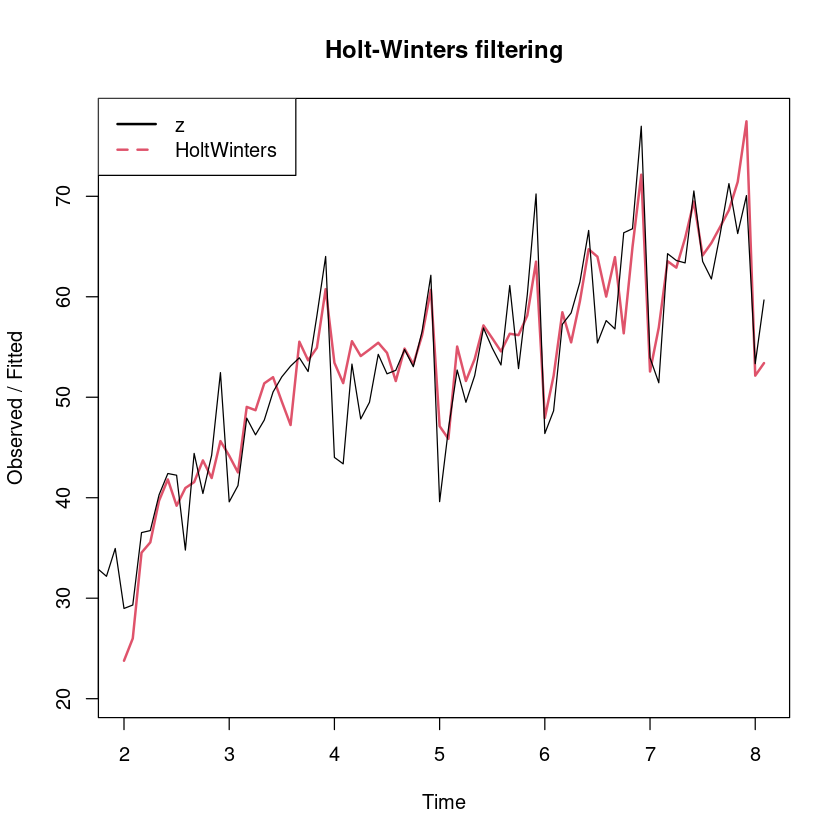

In [28]:
plot(export_smoothing, lwd=2, lty=1:2)
legend("topleft", legend=c("z", "HoltWinters"), col=1:2, lty=1:2, lwd=2)


`-` 예측오차분석

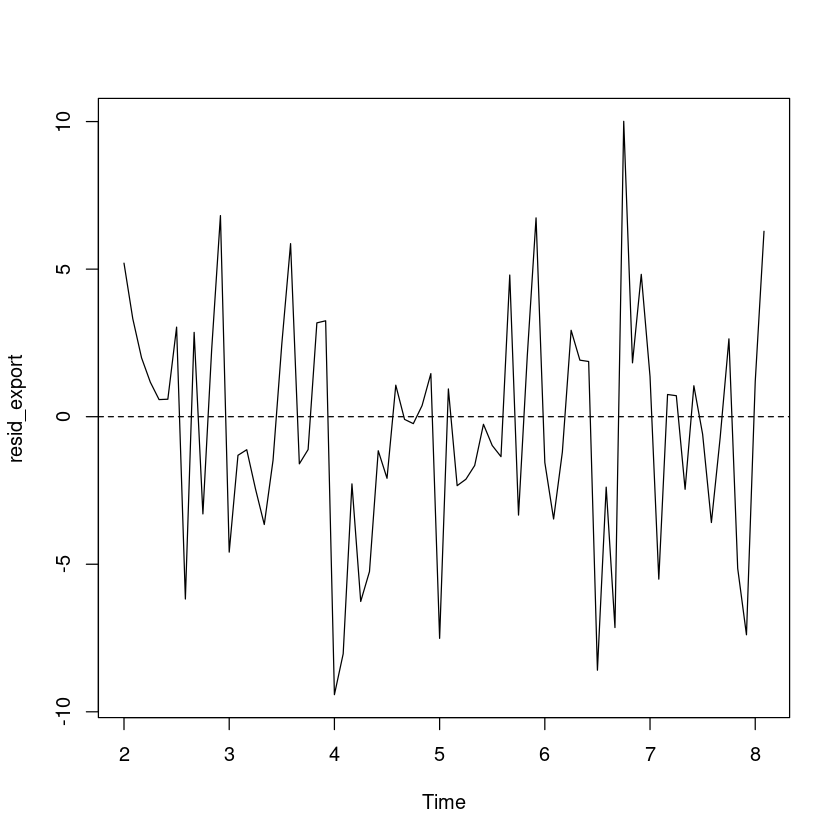

In [29]:
resid_export <- resid(export_smoothing)
plot.ts(resid_export)
abline(h=0, lty=2)

- 예측오차의 경우 0을 중심으로 대칭이고, 이분산성은 없어 보인다

In [30]:
t.test(resid_export)



	One Sample t-test

data:  resid_export
t = -0.99304, df = 73, p-value = 0.324
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -1.359825  0.455374
sample estimates:
 mean of x 
-0.4522256 


- t-test 결과 예측오차의 평균은 0이라고 할 수 있다.

In [31]:
lmtest::dwtest(lm(resid_export~1), alternative="two.sided")


	Durbin-Watson test

data:  lm(resid_export ~ 1)
DW = 1.8163, p-value = 0.4267
alternative hypothesis: true autocorrelation is not 0


- DW test 결과 예측오차들 간의 자기 상관은 없는 것으로 보인다.

- 따라서 예측오차는 분석 결과 평활 결과는 적합하다고 할 수 있다.

- 2장에서 계절추세 모형을 적합한 경우에는 예측오차 간에 자기 상관이 있다는 결과
를 얻었었는데, 평활을 이용한 결과 자기상관이 제거되었다.

`-` 계절추세모형

In [32]:
seasonal_I <- as.factor(cycle(z_ts))
t <- 1:length(z)
m2 <- lm(z~t+seasonal_I)
m3 <- lm(z~t+I(t^2)+seasonal_I)

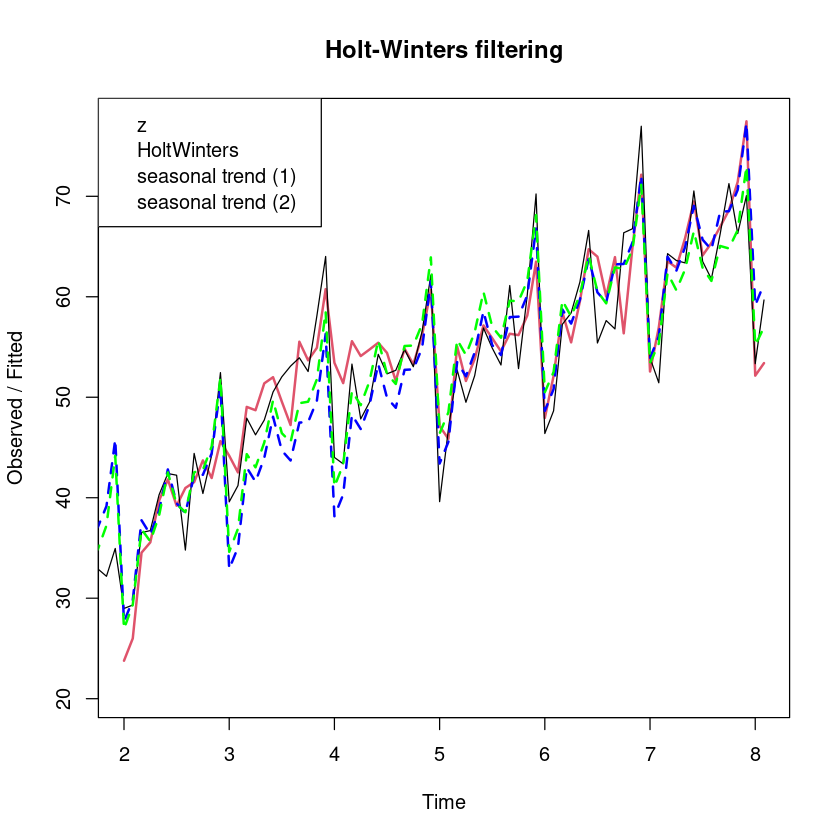

In [34]:
plot(export_smoothing, lwd=2, lty=1:2)
lines(ts(fitted(m2), frequency=12), col='blue', lty=2, lwd=2)
lines(ts(fitted(m3), frequency=12), col='green', lty=2, lwd=2)
legend("topleft", legend=c("z", "HoltWinters", "seasonal trend (1)", "seasonal trend (2)"))

`-` SSE 비교하기


In [35]:
head(export_smoothing$fitted) ## 평활값은 12시차 이후값부터 생성됨

,xhat,level,trend,season
Jan 2,23.77825,28.21682,0.8502812,-5.2888542
Feb 2,25.99728,30.78616,0.9253878,-5.7142708
Mar 2,34.53331,32.80963,0.9733636,0.7503125
Apr 2,35.55911,34.44285,1.0021933,0.1140625
May 2,39.71058,35.83200,1.0190994,2.8594792
Jun 2,41.81786,37.04258,1.0274655,3.7478125


In [36]:
sse_smoothing <- sum((z[-(1:12)]-export_smoothing$fitted[,1])^2) #또는
sse_smoothing <- export_smoothing$SSE


In [37]:
sse_m2 <- sum(resid(m2)^2)
sse_m3 <- sum(resid(m3)^2)

In [38]:
paste0("SSE_smomthing = ",sse_smoothing)
paste0("SSE_m2 = ", sse_m2)
paste0("SSE_m3 = ", sse_m3)


[1] "SSE_smomthing = 1135.42182593918"

[1] "SSE_m2 = 1371.05731181319"

[1] "SSE_m3 = 934.603221419272"

- 모형을 1시차 예측오차에 대한 제곱합으로 비교하면 2차추세모형을 적합한 m3의
SSE값이 가장 작고, 1차선형추세를 사용한 모형의 SSE가 가장 크다.

In [39]:
mse_smoothing <- mean((z[-(1:12)]-export_smoothing$fitted[,1])^2)
mse_m2 <- mean(resid(m2)^2)
mse_m3 <- mean(resid(m3)^2)
paste0("MSE_smomthing = ",mse_smoothing)
paste0("MSE_m2 = ", mse_m2)
paste0("MSE_m3 = ", mse_m3)

[1] "MSE_smomthing = 15.3435381883673"

[1] "MSE_m2 = 15.9425268815487"

[1] "MSE_m3 = 10.8674793188287"

- MSE로 비교하여도 결과는 같다.

# 3

## (1)

In [40]:
dt <- read.csv('data1.csv')
head(dt)

,X,t,z
,<int>,<int>,<dbl>
1,1,1,-1.5346871
2,2,2,2.6850469
3,3,3,-0.4288189
4,4,4,1.3724199
5,5,5,-0.9800884
6,6,6,2.4156505


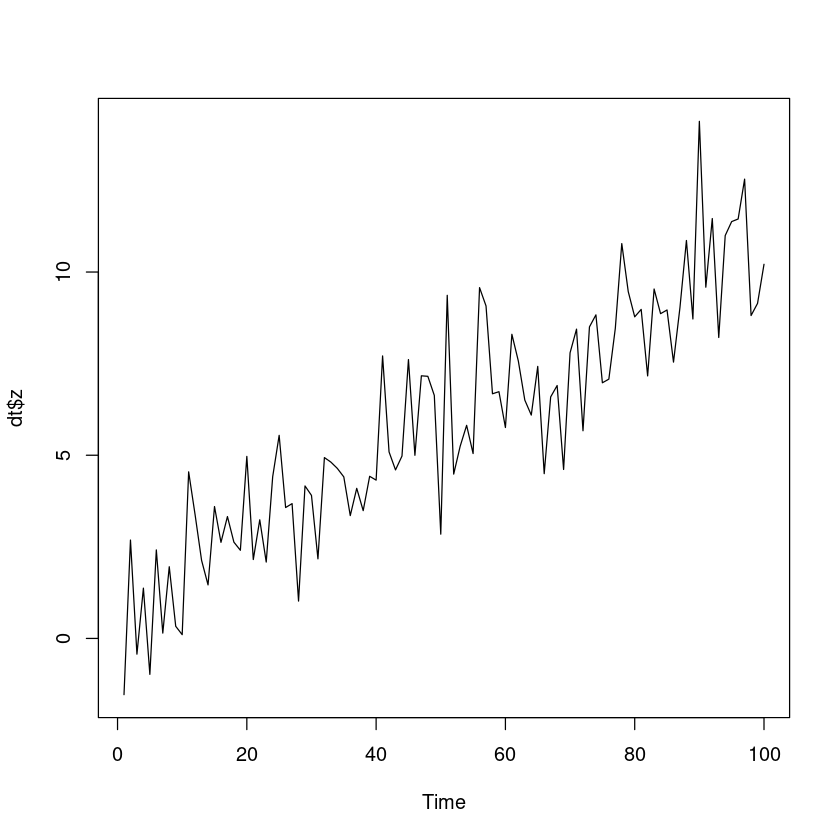

In [41]:
plot.ts(dt$z)


- 추세가 있음, 계절성분은 없음

- 선형추세 모형 적합

In [42]:
m_trend <- lm(z~t, dt)
summary(m_trend)



Call:
lm(formula = z ~ t, data = dt)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.0803 -1.0287  0.0169  0.8426  4.3288 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.818932   0.296301   2.764  0.00682 ** 
t           0.099619   0.005094  19.557  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.47 on 98 degrees of freedom
Multiple R-squared:  0.796,	Adjusted R-squared:  0.7939 
F-statistic: 382.5 on 1 and 98 DF,  p-value: < 2.2e-16


- 모형 적합이 잘 되었음.

- $\hat Z = 0.82 + 0.10t$

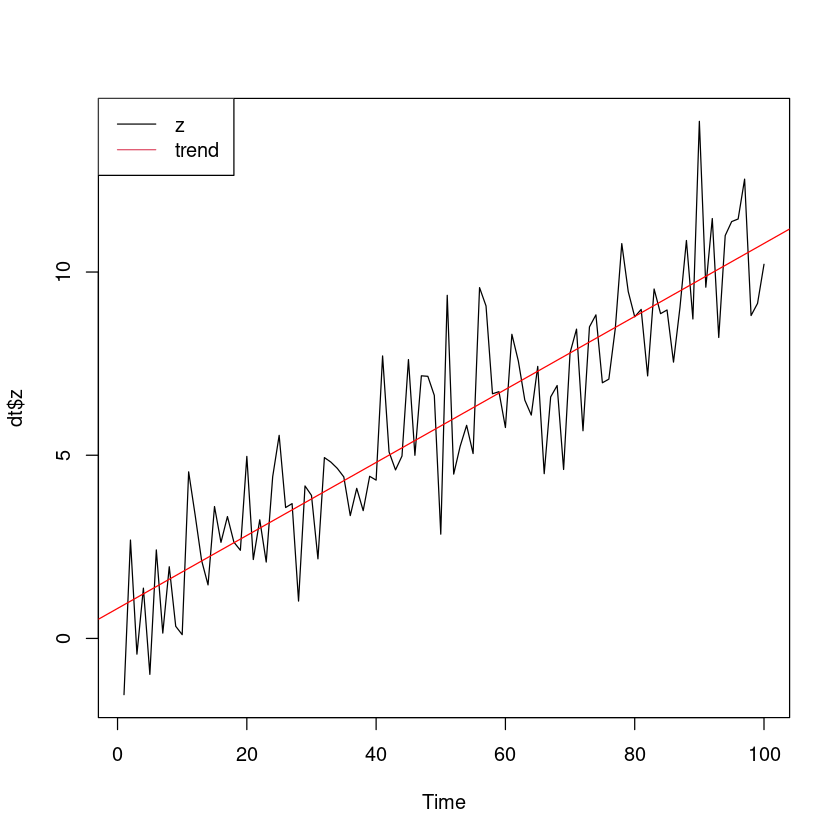

In [43]:
plot.ts(dt$z)
abline(m_trend, col='red')
legend("topleft", c("z", "trend"), lty=1, col=1:2)

`-` 잔차분석

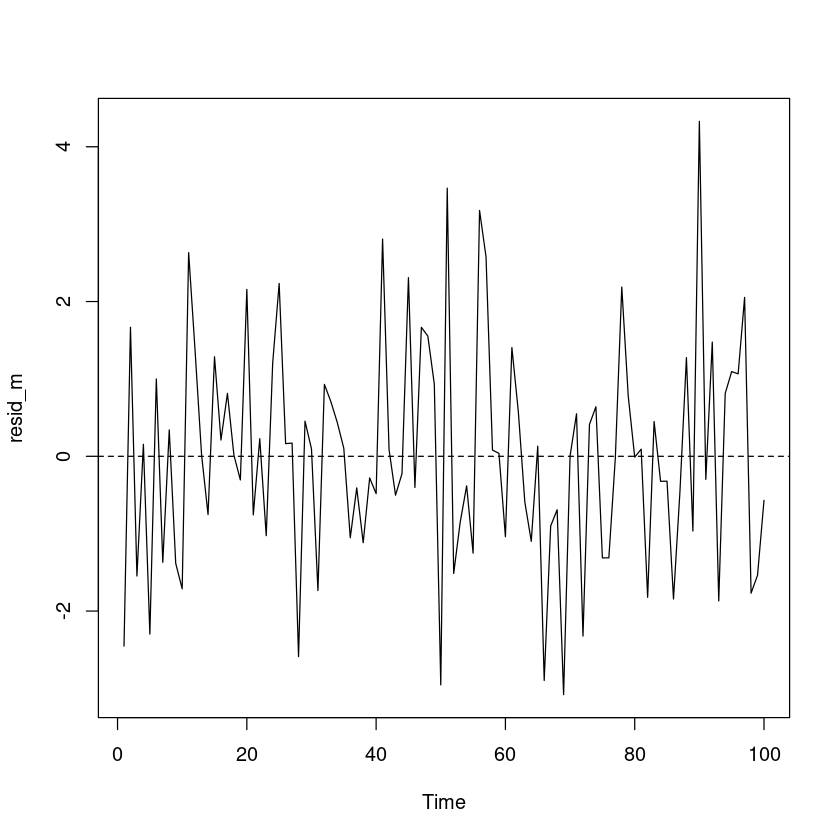

In [44]:
resid_m <- resid(m_trend)
plot.ts(resid_m)
abline(h=0, lty=2)

- 잔차의 경우 0을 중심으로 대칭이고, 이분산성은 없어 보인다.

In [45]:
t.test(resid_m)


	One Sample t-test

data:  resid_m
t = -5.2362e-16, df = 99, p-value = 1
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.2902834  0.2902834
sample estimates:
    mean of x 
-7.660376e-17 


- t-test 결과 예측오차의 평균은 0이라고 할 수 있다

In [46]:
lmtest::dwtest(m_trend)


	Durbin-Watson test

data:  m_trend
DW = 2.2164, p-value = 0.8389
alternative hypothesis: true autocorrelation is greater than 0


- DW test 결과 잔차들 간의 자기 상관은 없는 것으로 보인다.

- 따라서 잔차 분석 결과 추세모형 결과는 적절하다고 할 수 있다.

## (2)

In [47]:
new_dt <- data.frame(t=100+(1:10))
pred_trend <- predict(m_trend, new_dt)
pred_trend


1        2        3        4        5        6        7        8 
10.88044 10.98006 11.07968 11.17930 11.27892 11.37854 11.47816 11.57777 
       9       10 
11.67739 11.77701

## (3)

- 추세만 있으므로 이중지수평활 적용

In [48]:
m_smoothing <- HoltWinters(dt$z, gamma=FALSE)
m_smoothing

Holt-Winters exponential smoothing with trend and without seasonal component.

Call:
HoltWinters(x = dt$z, gamma = FALSE)

Smoothing parameters:
 alpha: 0.496601
 beta : 0.396225
 gamma: FALSE

Coefficients:
        [,1]
a  9.7266353
b -0.3150449

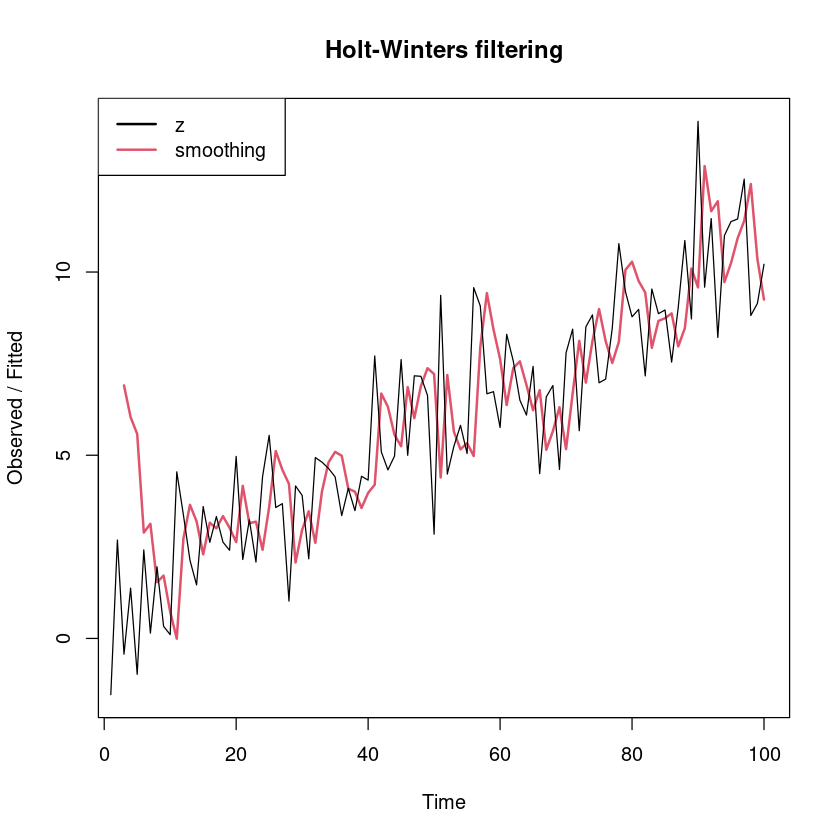

In [49]:
plot(m_smoothing, lwd=2)
legend("topleft", legend=c("z","smoothing"), lty=1, lwd=2, col=1:2)

`-` 예측오차 분석

In [50]:
resid_smoothing <- dt$z[-(1:2)] - m_smoothing$fitted[,1] #또는
resid_smoothing <- resid(m_smoothing) #같은 방법임

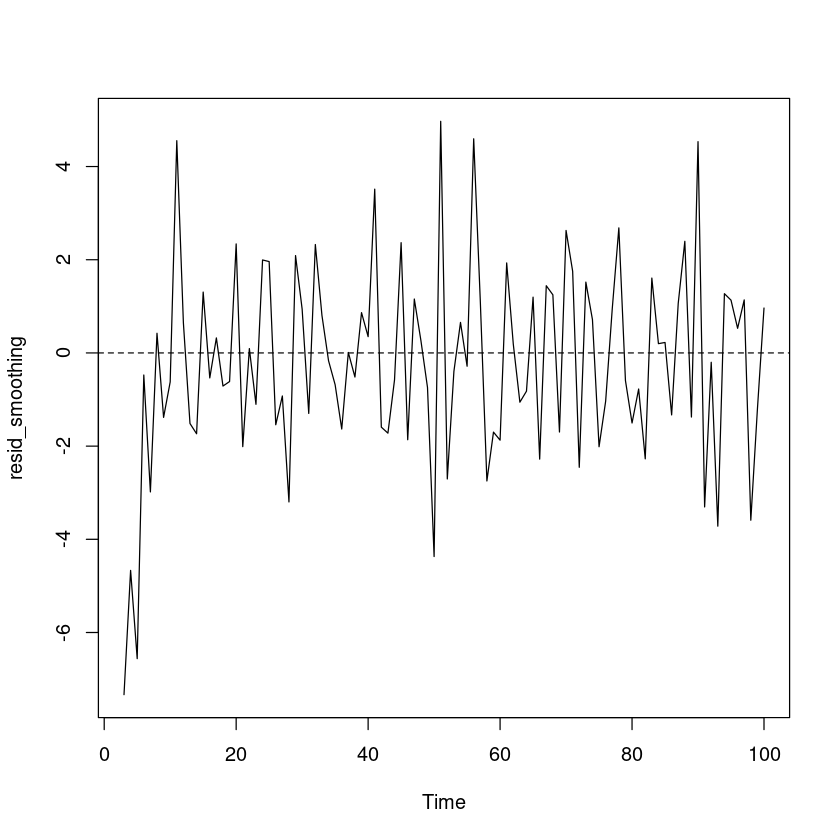

In [51]:
plot.ts(resid_smoothing)
abline(h=0, lty=2)


- 예측오차의 경우 0을 중심으로 대칭이고, 이분산성은 없어 보인다.

In [52]:
t.test(resid_smoothing)



	One Sample t-test

data:  resid_smoothing
t = -1.0711, df = 97, p-value = 0.2868
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.6709125  0.2005740
sample estimates:
 mean of x 
-0.2351693 


- t-test 결과 예측오차의 평균은 0이라고 할 수 있다.

In [53]:
lmtest::dwtest(lm(resid_smoothing~1), alternative="two.sided")



	Durbin-Watson test

data:  lm(resid_smoothing ~ 1)
DW = 1.9664, p-value = 0.8675
alternative hypothesis: true autocorrelation is not 0


- DW test 결과 예측오차들 간의 자기 상관은 없는 것으로 보인다.

- 따라서 예측오차는 분석 결과 평활 결과는 적절하다고 할 수 있다.


## (4)

In [54]:
pred_smoothing <- predict(m_smoothing, n.ahead=10, prediction.interval = T, level=0.95)
pred_smoothing


,fit,upr,lwr
101,9.411590,13.67142,5.1517644
102,9.096545,14.28017,3.9129175
103,8.781500,15.20395,2.3590541
104,8.466456,16.38382,0.5490889
105,8.151411,17.77356,-1.4707380
106,7.836366,19.34098,-3.6682458
107,7.521321,21.06388,-6.0212357
108,7.206276,22.92649,-8.5139377
109,6.891231,24.91716,-11.1346959
110,6.576186,27.02692,-13.8745530


In [60]:
forecast::holt(dt$z, alpha = m_smoothing$alpha, beta=m_smoothing$beta, h=10)#, initial)

    Point Forecast       Lo 80    Hi 80      Lo 95    Hi 95
101       8.862685   6.0523463 11.67302   4.564643 13.16073
102       8.360702   4.5932352 12.12817   2.598859 14.12254
103       7.858719   2.6320999 13.08534  -0.134705 15.85214
104       7.356735   0.3034311 14.41004  -3.430363 18.14383
105       6.854752  -2.3086731 16.01818  -7.159497 20.86900
106       6.352769  -5.1561498 17.86169 -11.248603 23.95414
107       5.850786  -8.2094249 19.91100 -15.652451 27.35402
108       5.348803 -11.4485541 22.14616 -20.340538 31.03814
109       4.846819 -14.8590196 24.55266 -25.290661 34.98430
110       4.344836 -18.4296256 27.11930 -30.485697 39.17537

> 잘려서 뒤에가 뭐라고 써있는지를 모르겠음. initial값에 뭘 지정하는 것 같은데 똑같은 값이 안나온다

## (5)

In [61]:
real_new_dt <- read.csv("data1_new.csv")
real_new_dt

X,t,z
<int>,<int>,<dbl>
1,101,11.577471
2,102,13.171004
3,103,12.730258
4,104,12.242375
5,105,10.877077
6,106,13.297355
7,107,14.632224
8,108,15.049088
9,109,9.671734


In [62]:
min(dt$z)


[1] -1.534687

ERROR: Error in xy.coords(x, y): 'x' and 'y' lengths differ


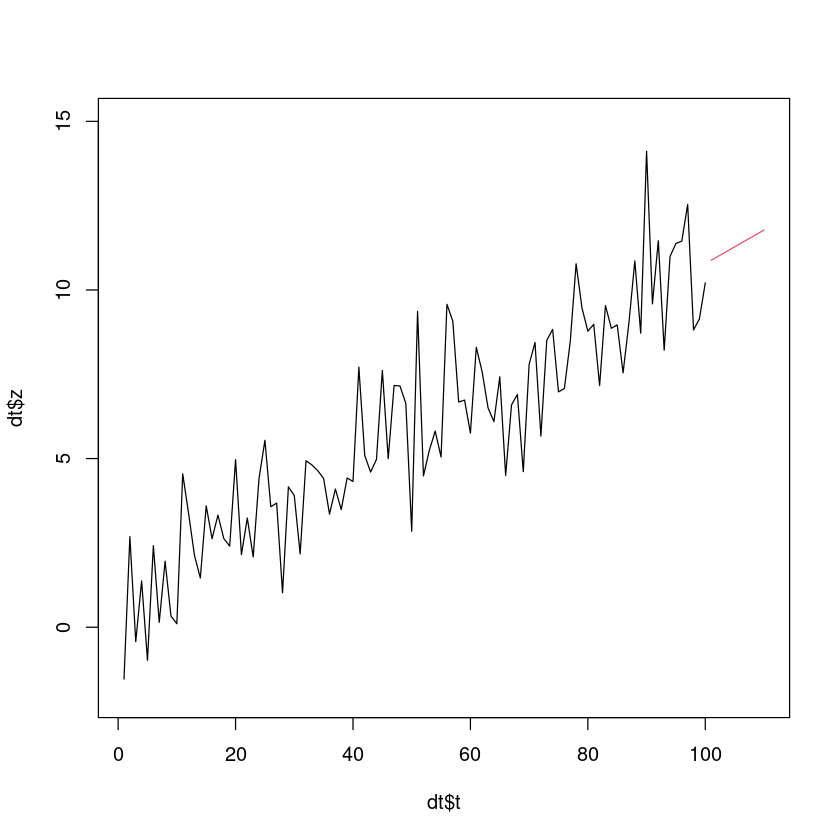

In [63]:
plot(dt$t,dt$z, xlim=c(1,110), ylim=c(-2, 15), type='l')
lines(101:110, pred_trend, col=2)
lines(101:110, pred_smoothing, col=3)

- MSE, MAPE, MAE 값을 이용하여 비교할 수 있다.

- $MSE = \dfrac{1}{m} \sum_{i=1}^n \hat e_{n-1+t}(1)^2$

- $MAPE = \dfrac{100}{n} \sum_{i=1}^n \left| \dfrac{\hat e_{n-1+t}(1)}{Z_{n+t}} \right|$

- $MAE = \dfrac{1}{m} \sum_{i=1}^m \left| \hat e_{n-1+t}(1) \right|$

In [64]:
e_trend <- real_new_dt$z - pred_trend
e_smoothing <- real_new_dt$z - pred_smoothing

In [65]:
(MSE_trend = mean(e_trend^2))
(MSE_smoothing = mean(e_smoothing^2))
(MAPE_trend = 100 * sum(abs(e_trend/ real_new_dt$z)) / 10)
(MAPE_smoothing = 100 * sum(abs(e_smoothing/ real_new_dt$z)) / 10)
(MAE_trend = mean(abs(e_trend)))
(MAE_smoothing = mean(abs(e_smoothing)))


[1] 3.919789

[1] 127.1734

[1] 13.13854

[1] 218.7356

[1] 1.699274

[1] 9.027502

> 교수님 풀이랑 smoothing 의 값이 좀 다르다.

- 어떤 값을 보나 1차선형 추세 모형이 예측을 더 잘했다고 할 수 있다.

- 추세가 전체적으로 변하지 않는 경우에는 평활법보다는 선형추세 모형이 더 적합하
다고 할 수 있다.


# 4

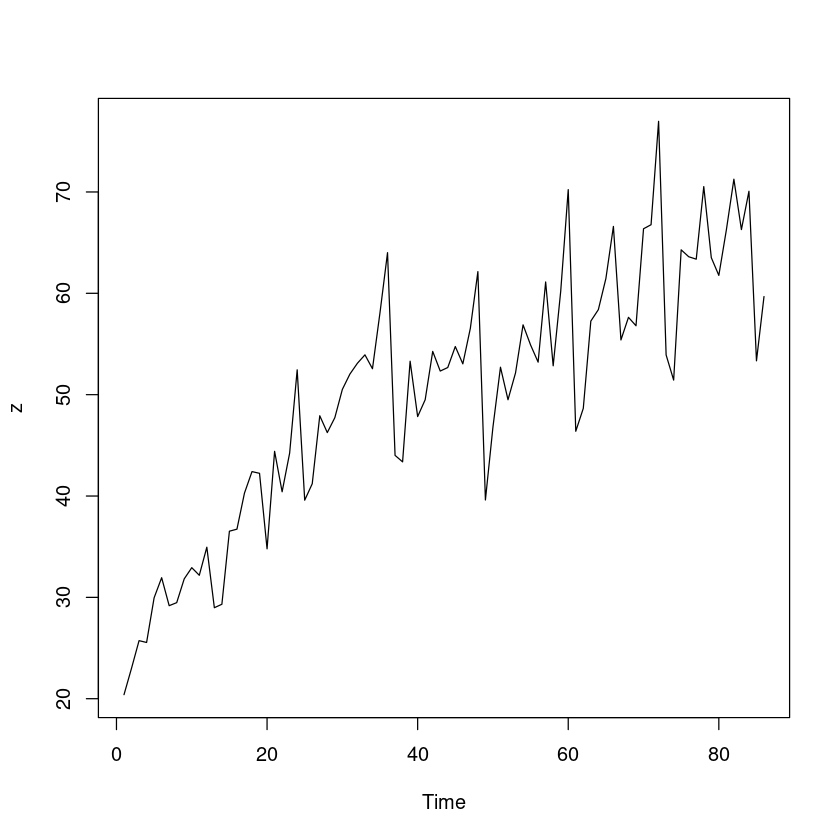

In [66]:
z <- scan('export.txt')
plot.ts(z)

## (1)

- 위에서 2차선형추세 모형이 더 적절했다고 했으므로, 2차 추세 모형을 적합한다.

In [67]:
z_ts <- ts(z, frequency=12)
seasonal_I <- as.factor(cycle(z_ts))
t <- 1:length(z)


In [68]:
dec1_trend <- fitted(lm(z~t+I(t^2))) ## 추세성분

In [69]:
adjtrend = z-dec1_trend
dec1_seasonal <- fitted(lm(adjtrend ~ 0+seasonal_I)) ## 계절성분

In [70]:
dec1_irr = z-dec1_trend-dec1_seasonal ## 불규칙 성분

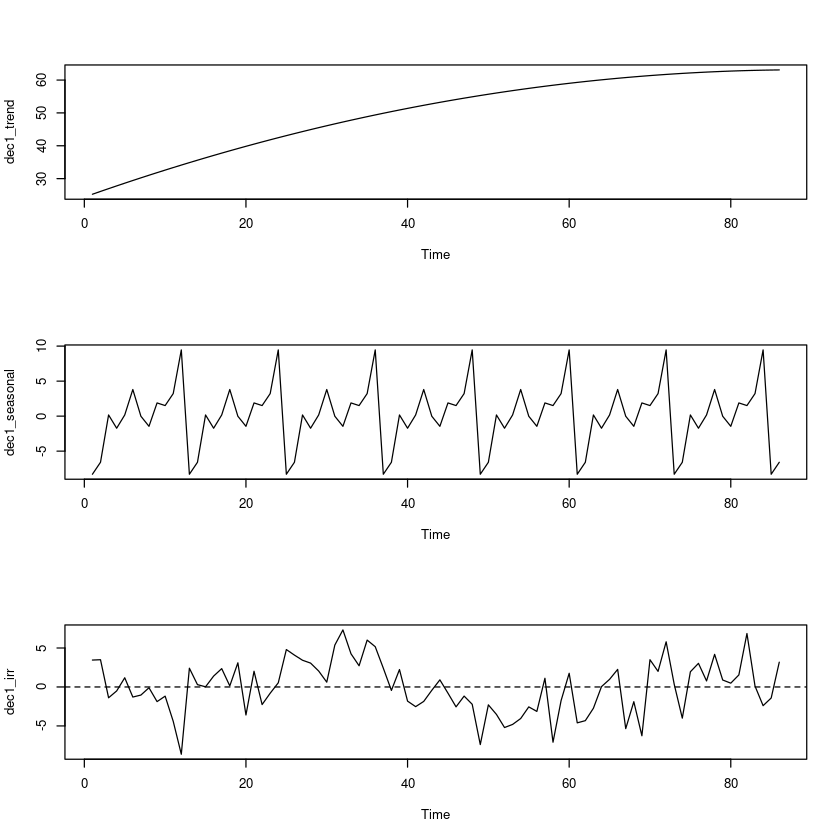

In [71]:
par(mfrow=c(3,1))
plot.ts(dec1_trend)
plot.ts(dec1_seasonal)
plot.ts(dec1_irr)
abline(h=0, lty=2)
par9mfrow=c(1,1)

## (2)

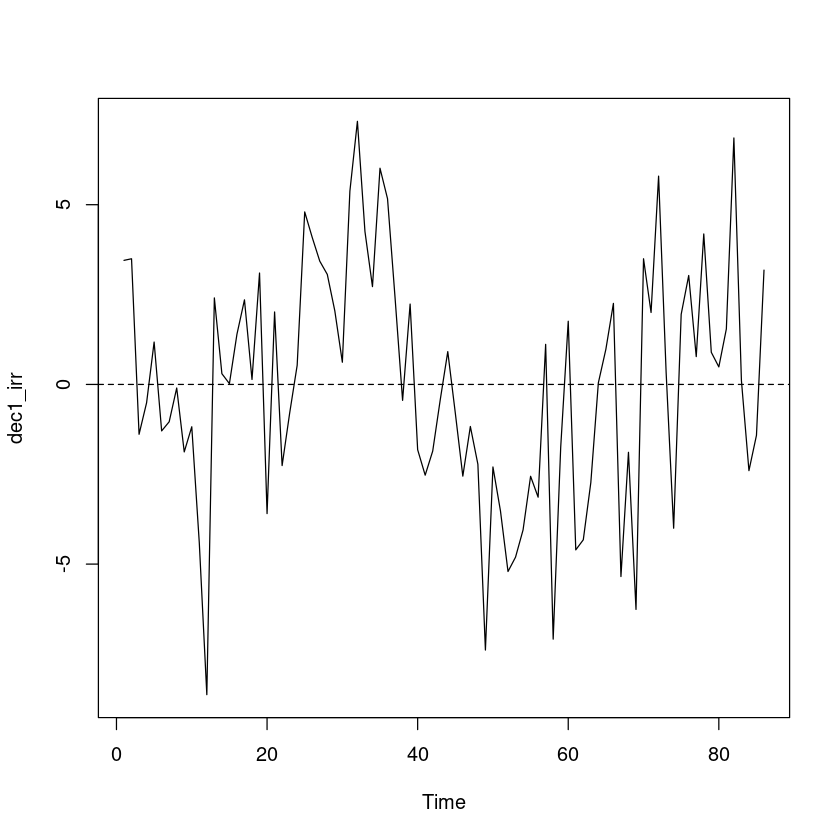

In [72]:
plot.ts(dec1_irr)
abline(h=0, lty=2)

- 예측오차의 경우 0을 중심으로 대칭이고, 이분산성은 보이지 않는다.


In [73]:
t.test(dec1_irr)


	One Sample t-test

data:  dec1_irr
t = 2.2831e-16, df = 85, p-value = 1
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.7179805  0.7179805
sample estimates:
   mean of x 
8.244475e-17 


- t-test 결과 예측오차의 평균은 0이라고 할 수 있다.


In [74]:
lmtest::dwtest(lm(dec1_irr~1), alternative="two.sided")


	Durbin-Watson test

data:  lm(dec1_irr ~ 1)
DW = 1.1429, p-value = 2.78e-05
alternative hypothesis: true autocorrelation is not 0


- DW test 결과 예측오차들 간의 자기 상관은 있는 것으로 보인다.

- 오차들간의 상관관계가 있는 것을 제외하고는 적절하다고 볼 수 있다.


## (3)

- 이분산성을 보이지 않기 때문에 가법 모형을 사용

- decompose 함수 사용

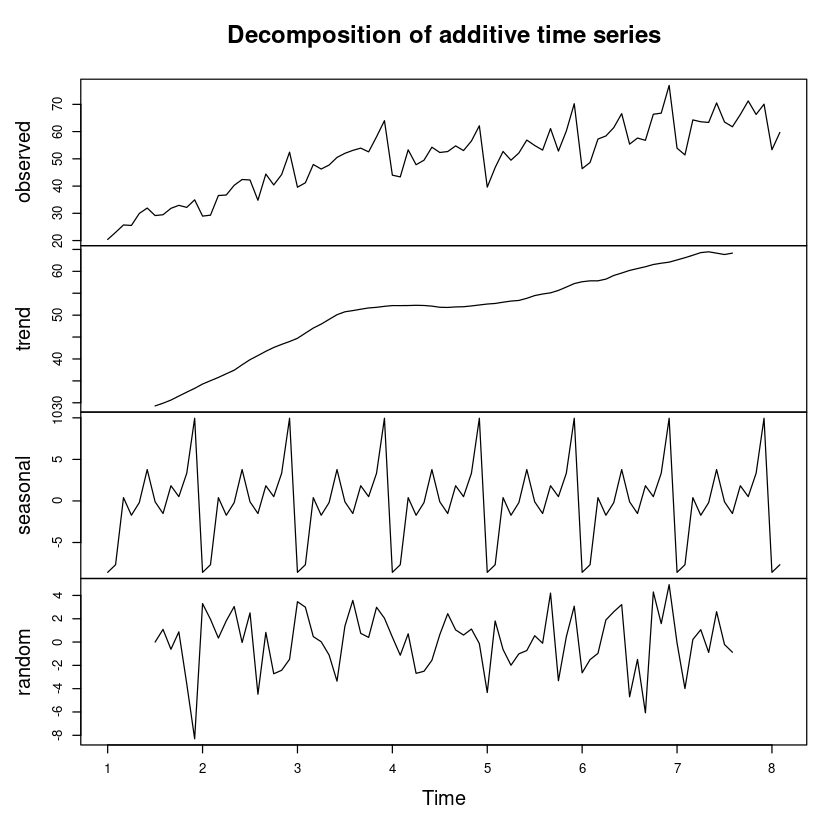

In [75]:
dec_fit <- decompose(z_ts, 'additive')
plot(dec_fit)


## (4)

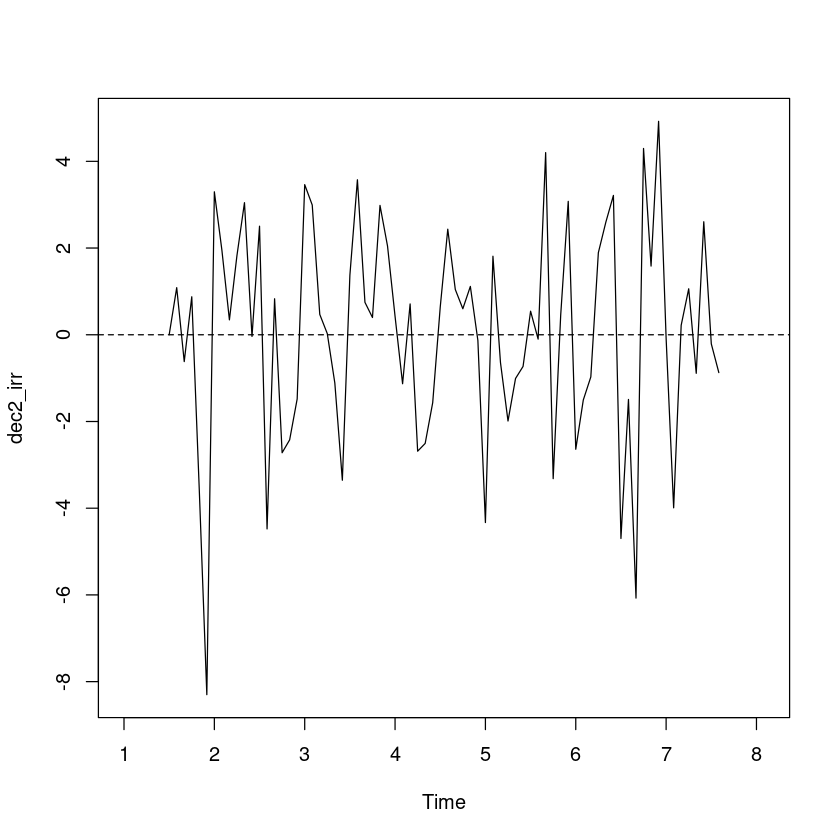

In [76]:
dec2_irr <- dec_fit$random
plot.ts(dec2_irr)
abline(h=0, lty=2)


예측오차의 경우 0을 중심으로 대칭이고, 이분산성은 없어 보인다.


In [78]:
t.test(dec2_irr)



	One Sample t-test

data:  dec2_irr
t = 0.074013, df = 73, p-value = 0.9412
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.5674456  0.6112171
sample estimates:
 mean of x 
0.02188575 


- t-test 결과 예측오차의 평균은 0이라고 할 수 있다

In [79]:
lmtest::dwtest(lm(dec2_irr~1), alternative="two.sided")


	Durbin-Watson test

data:  lm(dec2_irr ~ 1)
DW = 1.9469, p-value = 0.8188
alternative hypothesis: true autocorrelation is not 0


- DW test 결과 예측오차들 간의 자기 상관은 없는 것으로 보인다.

- 따라서 예측오차는 분석 결과 평활 결과는 적절하다고 할 수 있다.

- 추세를 이용한 분해법에서 예측 오차는 상관관계가 있었지만, 평활법을 사용하면서
예측오차들의 상관관계를 제거할 수 있었다.


## (5)

In [80]:
sse_1 = sum(dec1_irr^2)
sse_2 = sum(dec2_irr^2, na.rm=T)
paste0("SSE_1 = ", sse_1)
paste0("SSE_2 = ", sse_2)

[1] "SSE_1 = 953.219486362055"

[1] "SSE_2 = 472.381499188028"

- SSE 값을 비교하였을 때, 평활에 의한 분해법의 값이 더 작다.


In [81]:
mse_1 = mean(dec1_irr^2)
mse_2 = mean(dec2_irr^2, na.rm=T)
paste0("MSE_1 = ", mse_1)
paste0("MSE_2 = ", mse_2)


[1] "MSE_1 = 11.0839475158378"

[1] "MSE_2 = 6.38353377281119"

- MSE 값을 비교하여도 결과가 같다.

- 따라서 불규칙성분을 분석한 결과와 더불어 평활에 의한 분해법이 더 적절하다고
할 수 있다.


# 5

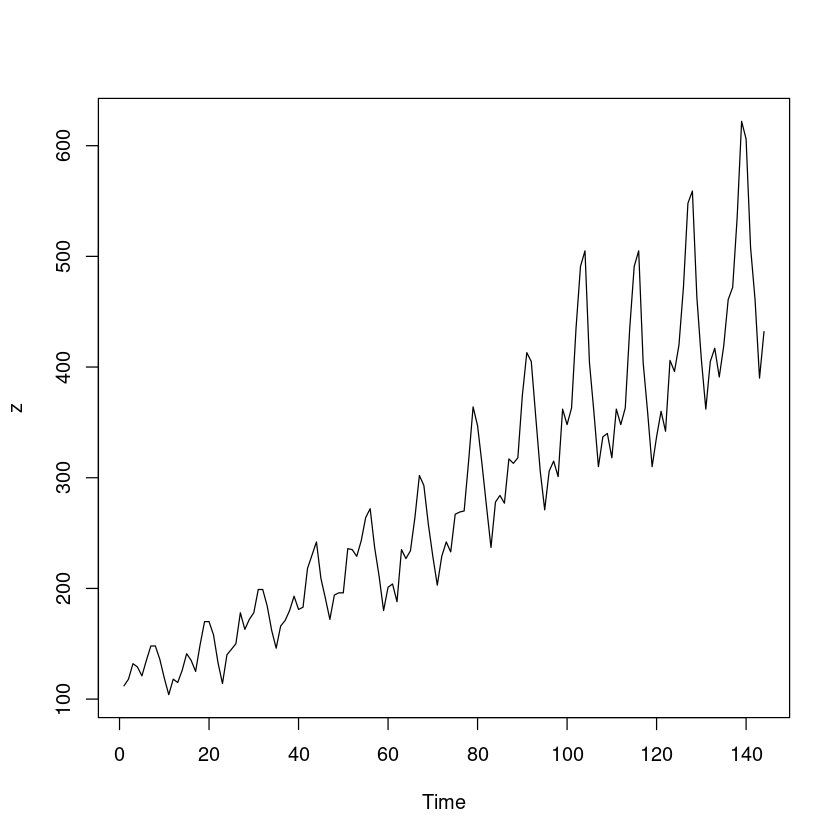

In [82]:
z <- scan('usapass.txt')
plot.ts(z)

## (1)

- 계절성분의 진폭이 시간이 흐름에 따라 증가하고 있는 것을 볼 수 있다.

- 따라서 이분산성을 제거하기 위해 로그변환이 필요하다.


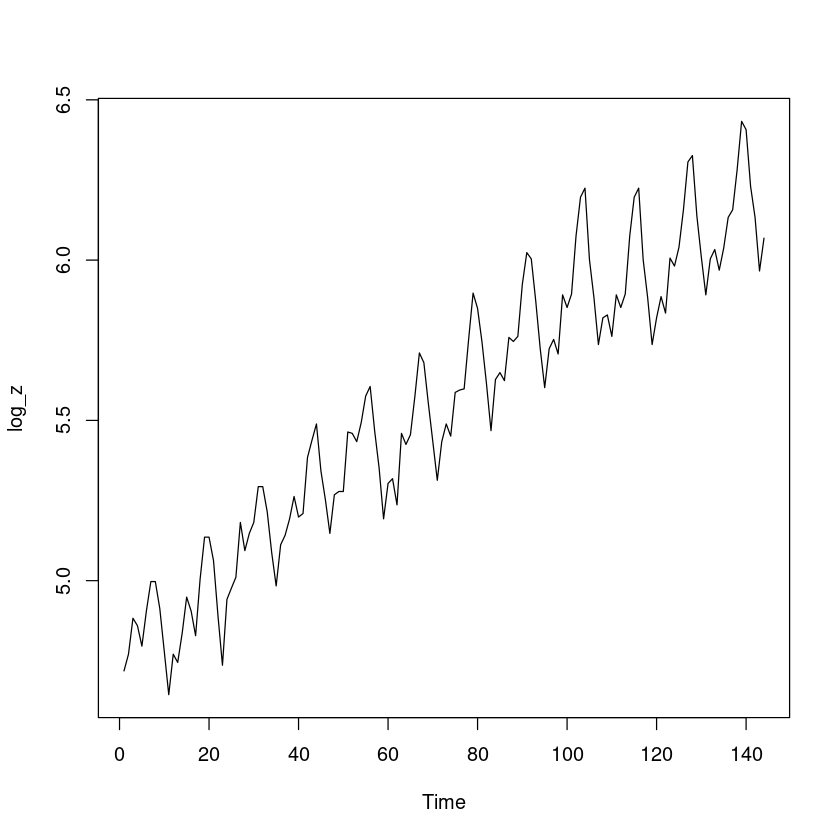

In [83]:
log_z <- log(z)
plot.ts(log_z)


- 로그변환을 통해 이분산성이 제거된 것을 확인할 수 있다.

- 이 자료에는 추세성분과 계절성분(주기 12)이 있다.


## (2)

- 지수함수를 사용한 계절형 추세모형을 적합한다.

In [84]:
z_ts <- ts(z, frequency=12)
log_z_ts = log(z_ts)
seasonal_I <- as.factor(cycle(log_z_ts))
t <- 1:length(z)
m_trend <- lm(log_z_ts~0+t+seasonal_I)
summary(m_trend)


Call:
lm(formula = log_z_ts ~ 0 + t + seasonal_I)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.159814 -0.044426  0.000623  0.045572  0.151846 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
t            0.0100999  0.0001252   80.67   <2e-16 ***
seasonal_I1  4.7246982  0.0198289  238.27   <2e-16 ***
seasonal_I2  4.7026123  0.0198822  236.52   <2e-16 ***
seasonal_I3  4.8342011  0.0199361  242.49   <2e-16 ***
seasonal_I4  4.8015084  0.0199907  240.19   <2e-16 ***
seasonal_I5  4.8009618  0.0200459  239.50   <2e-16 ***
seasonal_I6  4.9237482  0.0201017  244.94   <2e-16 ***
seasonal_I7  5.0296649  0.0201582  249.51   <2e-16 ***
seasonal_I8  5.0223242  0.0202153  248.44   <2e-16 ***
seasonal_I9  4.8708171  0.0202729  240.26   <2e-16 ***
seasonal_I10 4.7357833  0.0203312  232.93   <2e-16 ***
seasonal_I11 4.5905564  0.0203901  225.14   <2e-16 ***
seasonal_I12 4.7032829  0.0204496  229.99   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.

$\hat Z_t = 0.01t + 4.72I_1 + 4.70I_2 + \dots + 4.70I_{12}$

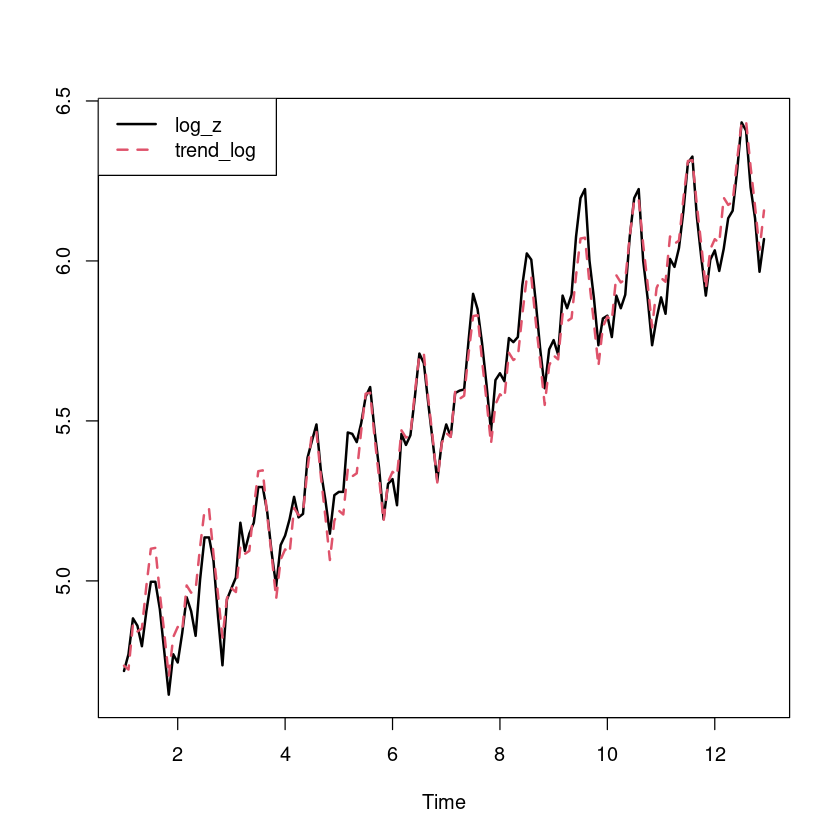

In [85]:
ts.plot(log_z_ts, ts(fitted(m_trend), frequency=12), col=1:2, lty=1:2, lwd=2)
legend("topleft", c("log_z", "trend_log"), col=1:2, lty=1:2, lwd=2)


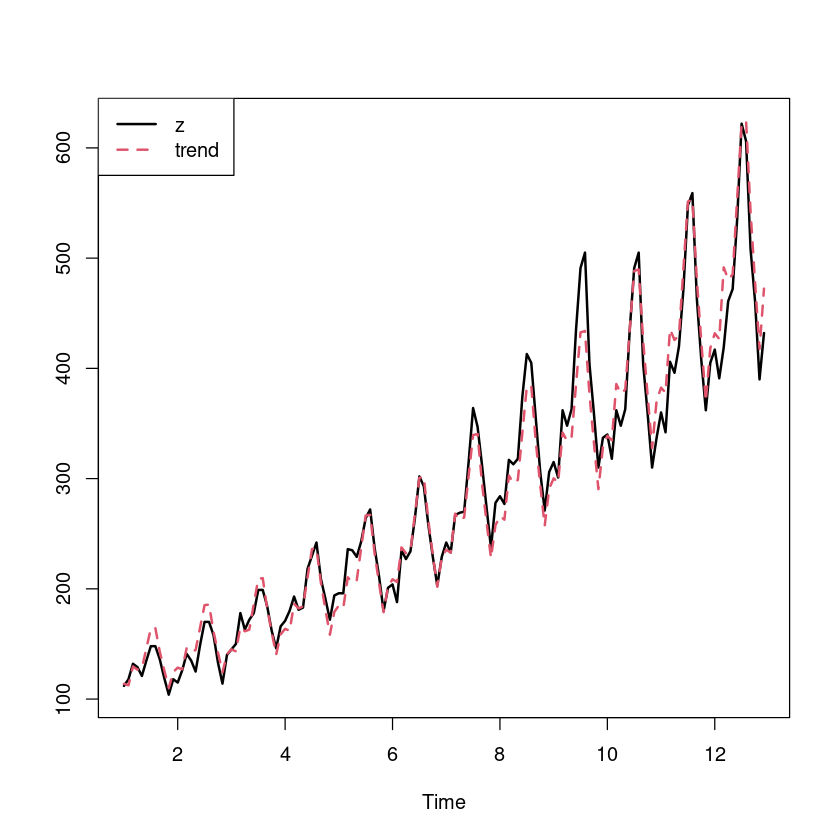

In [86]:
ts.plot(z_ts, ts(exp(fitted(m_trend)), frequency=12), col=1:2, lty=1:2, lwd=2)
legend("topleft", c("z", "trend"), col=1:2, lty=1:2, lwd=2)


`-` 잔차분석

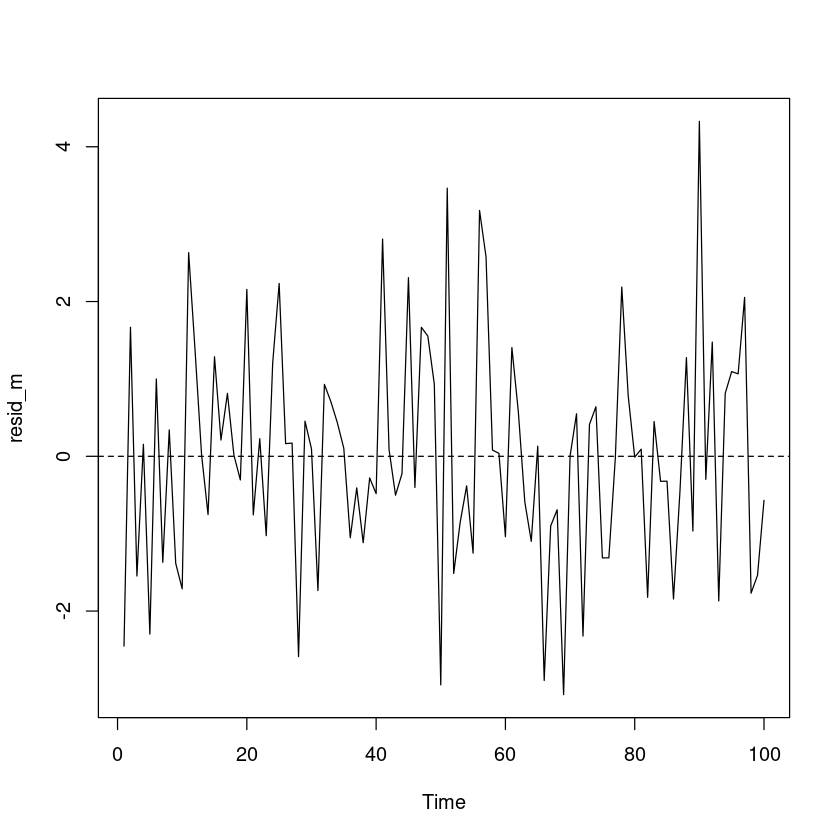

In [87]:
resid_trend <- resid(m_trend)
plot.ts(resid_m)
abline(h=0, lty=2)

- 잔차의 경우 0을 중심으로 대칭이고, 이분산성은 없어 보인다

In [88]:
t.test(resid_m)


	One Sample t-test

data:  resid_m
t = -5.2362e-16, df = 99, p-value = 1
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.2902834  0.2902834
sample estimates:
    mean of x 
-7.660376e-17 


- t-test 결과 예측오차의 평균은 0이라고 할 수 있다.

In [89]:
lmtest::dwtest(m_trend, alternative="two.sided")


	Durbin-Watson test

data:  m_trend
DW = 0.40831, p-value < 2.2e-16
alternative hypothesis: true autocorrelation is not 0


- DW test 결과 잔차들 간의 자기 상관이 있는 것으로 보인다.

- 따라서 잔차 분석 결과 추세모형 결과는 오차간의 자기 상관이 있는 것을 제외하면
적절해 보인다. 하지만 오차간의 자기상관을 제거할 필요가 있다.


## (3)

- 추세와 계절성분이 있으므로 계절평활평활을 사용한다.

- 로그변환한 데이터에 대해 가법 모형을 적용할 수도 있고, 원래 데이터에 대한 승법
모형을 적합할 수도 있다.

`-` 로그변환한 데이터에 대한 가법 모형

In [90]:
m_smoothing <- HoltWinters(log_z_ts)
m_smoothing

Holt-Winters exponential smoothing with trend and additive seasonal component.

Call:
HoltWinters(x = log_z_ts)

Smoothing parameters:
 alpha: 0.3447498
 beta : 0.003585913
 gamma: 0.879488

Coefficients:
            [,1]
a    6.165298459
b    0.008744433
s1  -0.073696849
s2  -0.142822821
s3  -0.039964334
s4   0.015968620
s5   0.033673237
s6   0.157016140
s7   0.300626468
s8   0.285698068
s9   0.098491289
s10 -0.021898771
s11 -0.190036243
s12 -0.096734648

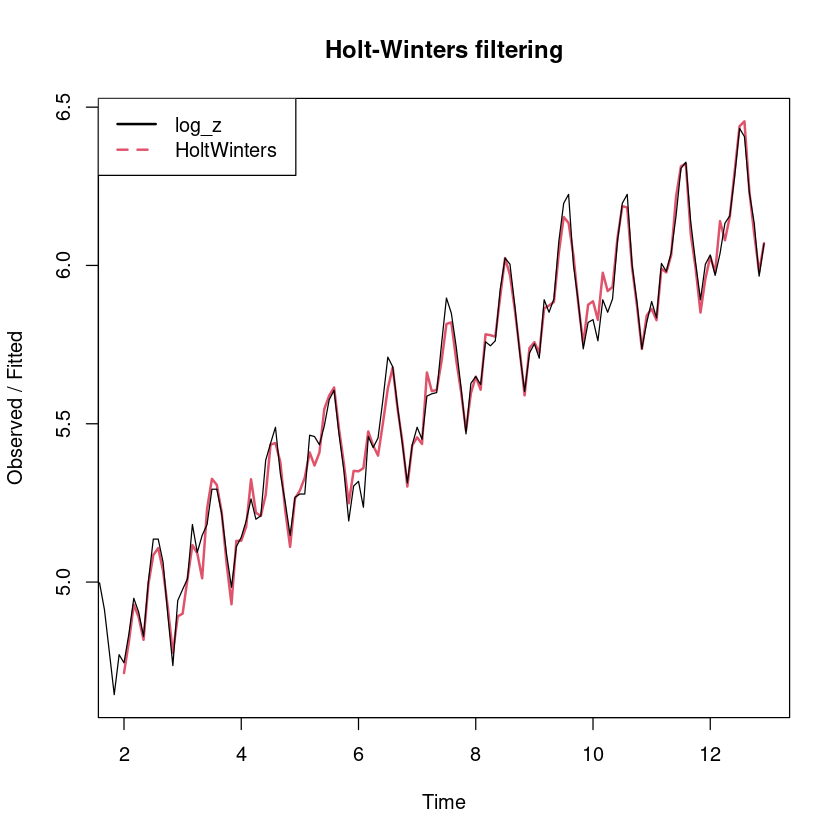

In [91]:
plot(m_smoothing, lwd=2, lty=1:2)
legend("topleft", legend=c("log_z", "HoltWinters"), col=1:2, lty=1:2, lwd=2)


`-` 잔차분석

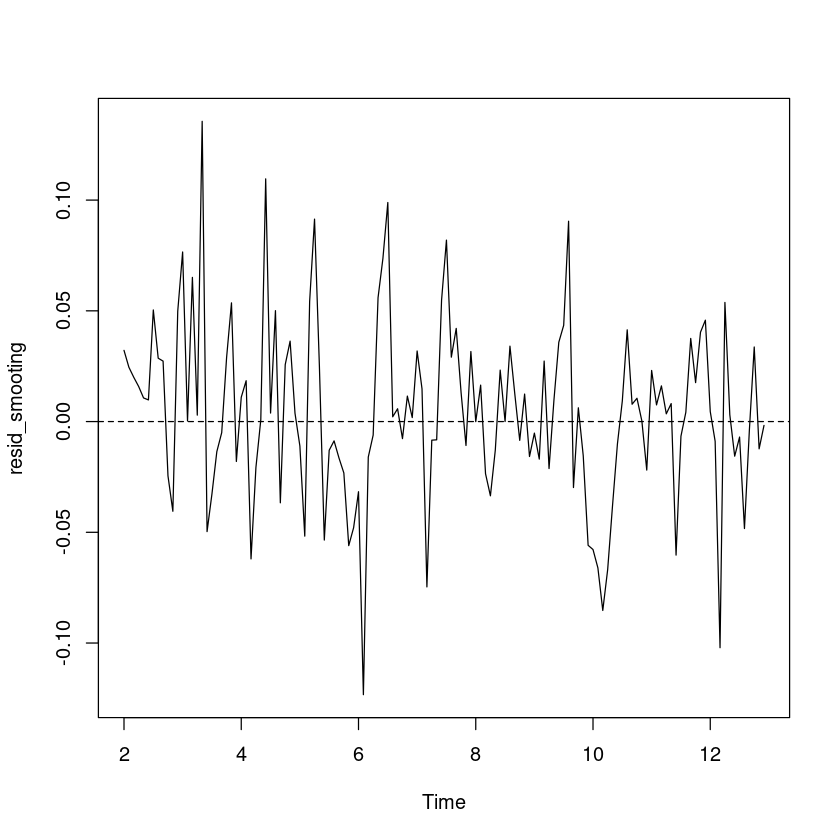

In [93]:
resid_smooting <- resid(m_smoothing)
plot.ts(resid_smooting)
abline(h=0, lty=2)

- 예측오차의 경우 0을 중심으로 대칭이고, 이분산성은 없어 보인다.


In [94]:
t.test(resid_smooting)


	One Sample t-test

data:  resid_smooting
t = 1.2026, df = 131, p-value = 0.2313
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.002766709  0.011346227
sample estimates:
  mean of x 
0.004289759 


- t-test 결과 예측오차의 평균은 0이라고 할 수 있다.

In [95]:
lmtest::dwtest(lm(resid_smooting~1), alternative="two.sided")


	Durbin-Watson test

data:  lm(resid_smooting ~ 1)
DW = 1.4549, p-value = 0.001604
alternative hypothesis: true autocorrelation is not 0


- DW test 결과 예측오차들 간의 자기 상관이 있는 것으로 보인다.

- 하지만, 추세모형을 적합하였을 때 얻어진 잔차에 비해 유의확률값이 크다.

- 예측오차는 분석 결과 추세모형 적합 결과보다는 평활 결과가 더 적절하다고 할 수
있다.


`-` 원 데이터에 대한 승법모형 적용


In [96]:
m_smoothing_multi <- HoltWinters(z_ts, seasonal = "multiplicative")
m_smoothing_multi 

Holt-Winters exponential smoothing with trend and multiplicative seasonal component.

Call:
HoltWinters(x = z_ts, seasonal = "multiplicative")

Smoothing parameters:
 alpha: 0.3204565
 beta : 0.02388265
 gamma: 1

Coefficients:
           [,1]
a   464.9721064
b     2.7859138
s1    0.9464640
s2    0.8810274
s3    0.9648716
s4    1.0334898
s5    1.0470250
s6    1.1793118
s7    1.3631491
s8    1.3399425
s9    1.1195987
s10   0.9993794
s11   0.8438225
s12   0.9290880

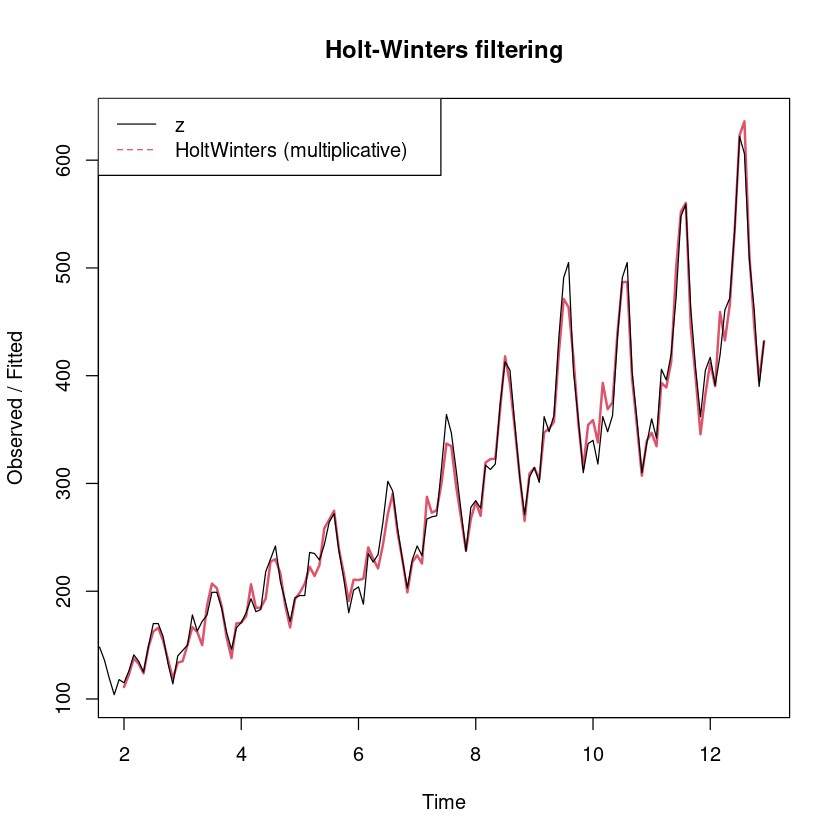

In [97]:
plot(m_smoothing_multi, lwd=2, lty=1:2)
legend("topleft", legend=c("z", "HoltWinters (multiplicative)"), col=1:2, lty=1:2)

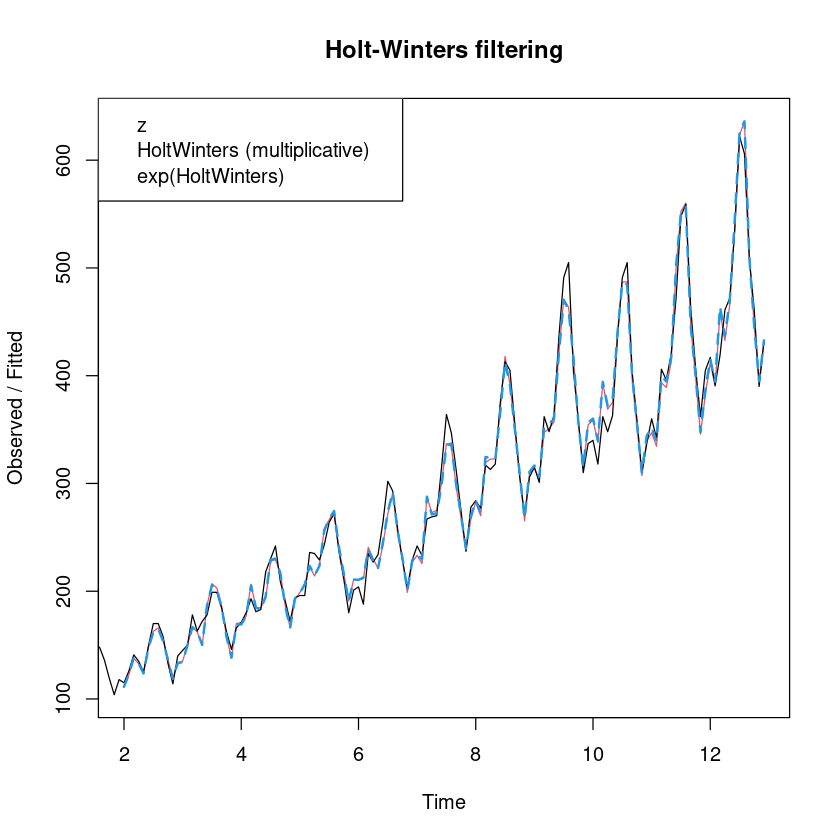

In [99]:
plot(m_smoothing_multi, lwd=1:2, lty=1:2)
lines(exp(m_smoothing$fitted[,1]), col=4, lty=2, lwd=2)
legend("topleft", legend=c("z", "HoltWinters (multiplicative)", "exp(HoltWinters)"))

`-` 승법모형에 대한 잔차분석


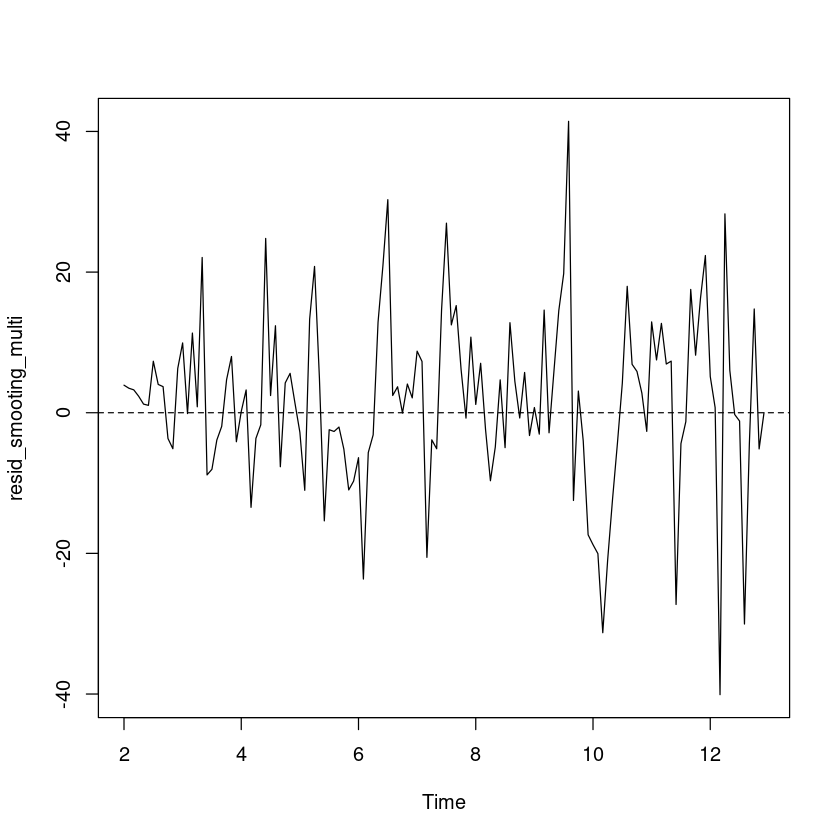

In [100]:
resid_smooting_multi <- resid(m_smoothing_multi)
plot.ts(resid_smooting_multi)
abline(h=0, lty=2)


- 예측오차의 경우 0을 중심으로 대칭이고, 이분산성은 없어 보인다.

In [101]:
t.test(resid_smooting_multi)



	One Sample t-test

data:  resid_smooting_multi
t = 1.5746, df = 131, p-value = 0.1178
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.4315512  3.7983414
sample estimates:
mean of x 
 1.683395 


- t-test 결과 예측오차의 평균은 0이라고 할 수 있다.


- DW test 결과 예측오차들 간의 자기 상관이 있는 것으로 보인다.

- 하지만, 추세모형을 적합하였을 때 얻어진 잔차에 비해 유의확률값이 크지만, 가법
모형을 사용한 평활법에 비하면 조금 크다.

- 차이가 크지 않지만, 가법 모형이 더 적절하다고 할 수 있다. 따라서 가법 모형 사용.


## (4)

- 로그변환한 데이터에 대한 가법모형을 사용하거나, 원래 데이터에 대한 승법 모형
적합 가능
- decompose 함수 사용

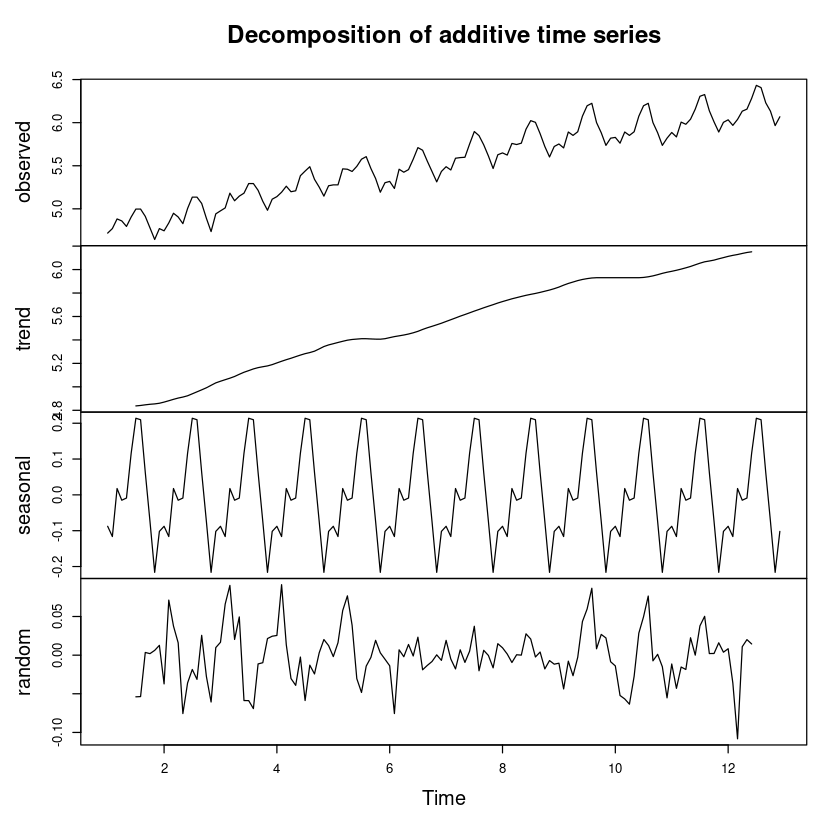

In [102]:
m_decompose_add <- decompose(log_z_ts, 'additive')
plot(m_decompose_add)

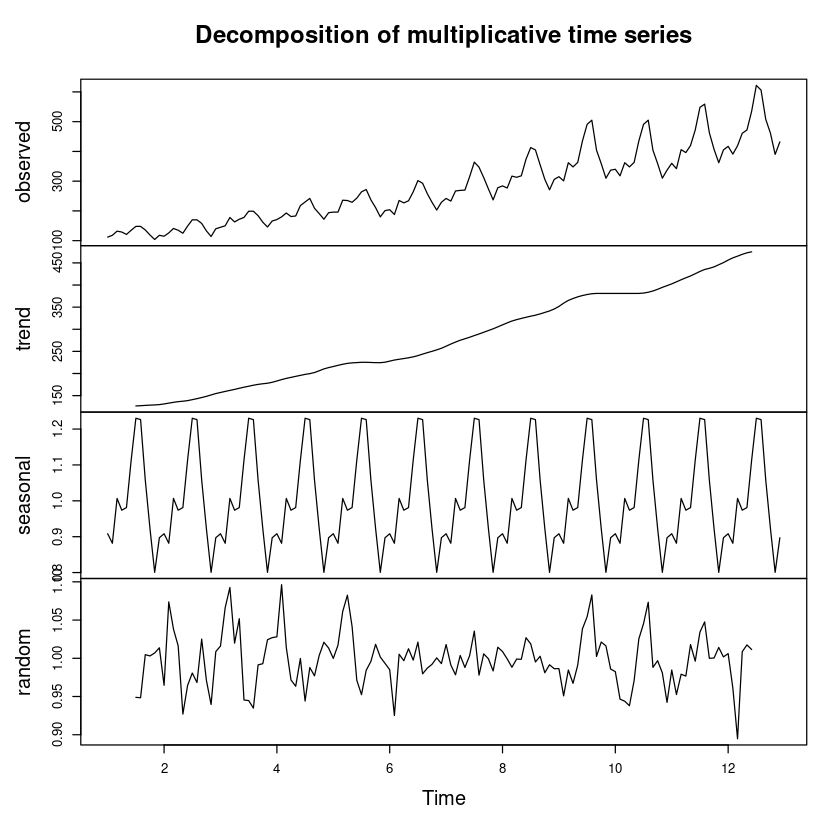

In [103]:
m_decompose_multi <- decompose(z_ts, 'multiplicative')
plot(m_decompose_multi)


In [104]:
fitted_dec_add <- m_decompose_add$trend + m_decompose_add$seasonal #가법모형은 더
fitted_dec_multi <- m_decompose_multi$trend * m_decompose_multi$seasonal #승법모

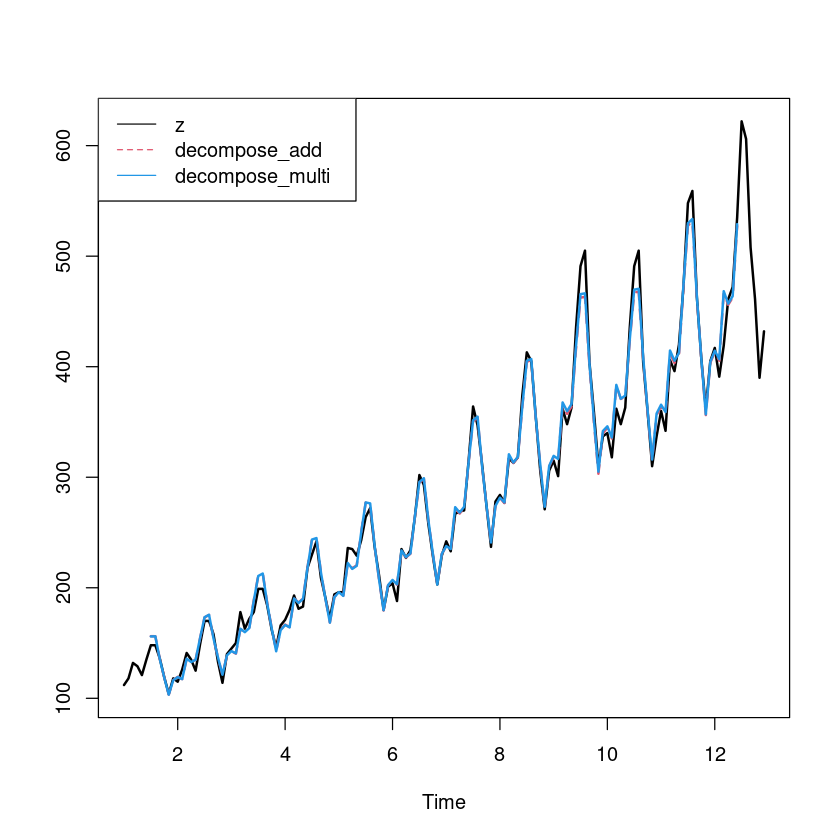

In [107]:
ts.plot(z_ts, exp(fitted_dec_add), fitted_dec_multi, col=c(1,2,4), lwd=2, lty=1:2)
legend("topleft", c("z","decompose_add", "decompose_multi"), col=c(1,2,4), lty=1:2)

- 가법모형과 승법 모형은 차이가 거의 없어 보임

`-` 잔차분석을 하라는 문제는 없었지만 한 번 해보겠음.

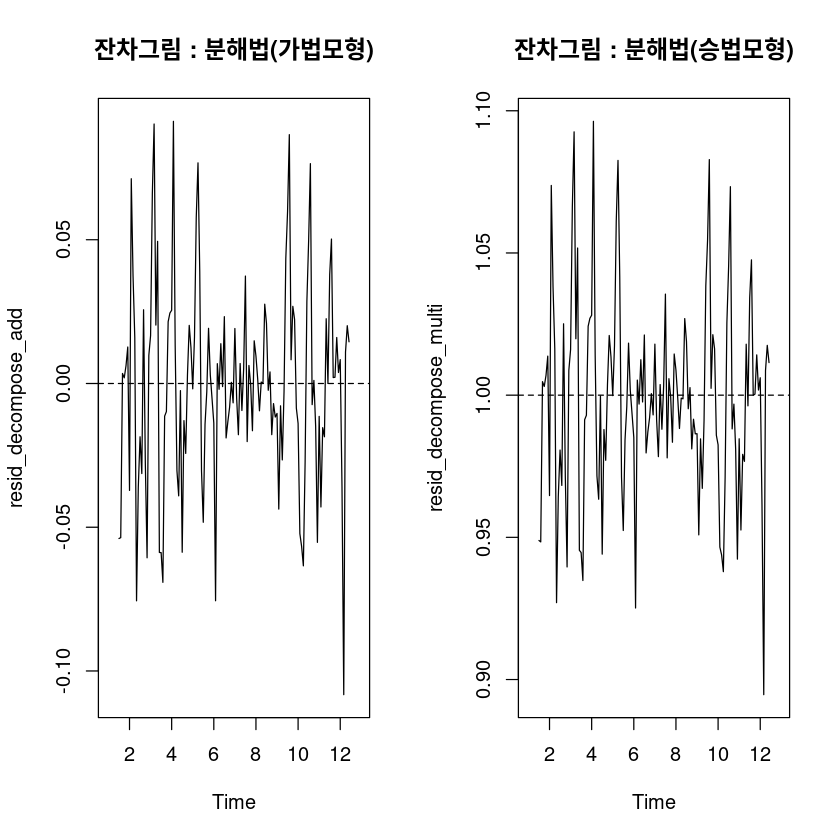

In [108]:
resid_decompose_add <- m_decompose_add$random
resid_decompose_multi <- m_decompose_multi$random
par(mfrow=c(1,2))
plot.ts(resid_decompose_add, main="잔차그림 : 분해법(가법모형)")
abline(h=0, lty=2)
plot.ts(resid_decompose_multi, main="잔차그림 : 분해법(승법모형)")
abline(h=1, lty=2)


- 가법모형의 경우 0을 중심으로 대칭이고, 승법모형의 경우 1을 중심으로 대칭이다.

- 두 경우 모두 이분산성은 없어 보인다.


In [109]:
t.test(resid_decompose_add)
t.test(resid_decompose_multi, mu=1)


	One Sample t-test

data:  resid_decompose_add
t = -0.28335, df = 131, p-value = 0.7774
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.006909609  0.005178249
sample estimates:
  mean of x 
-0.00086568 



	One Sample t-test

data:  resid_decompose_multi
t = -0.59098, df = 131, p-value = 0.5556
alternative hypothesis: true mean is not equal to 1
95 percent confidence interval:
 0.992186 1.004219
sample estimates:
mean of x 
0.9982026 


- t-test 결과 가법모형에서 예측오차의 평균은 0이라고 할 수 있고, 승법모형에서 예
측오차의 평균은 1이라고 할 수 있다

In [110]:
lmtest::dwtest(lm(resid_decompose_add~1), alternative="two.sided")
lmtest::dwtest(lm(resid_decompose_multi~1), alternative="two.sided")


	Durbin-Watson test

data:  lm(resid_decompose_add ~ 1)
DW = 1.1441, p-value = 7.258e-07
alternative hypothesis: true autocorrelation is not 0



	Durbin-Watson test

data:  lm(resid_decompose_multi ~ 1)
DW = 1.1426, p-value = 6.946e-07
alternative hypothesis: true autocorrelation is not 0


- DW test 결과 가법,승법 모두 예측오차들 간의 자기 상관이 있는 것으로 보인다.

## (5)

주의 : 예측오차의 제곱합을 구하기 위해서는 로그변환한 자료를 사용한 분석 방법
의 경우 지수함수를 이용한 역변환을 한 후 계산해야 한다.

In [111]:
e_trend <- z-exp(fitted(m_trend)) #추세모형을 적합한 경우의 예측오차
e_smoothing_add <- z[-(1:12)]-exp(m_smoothing$fitted[,1]) #평활(가법)을 적합한 경
e_smoothing_multi <- z[-(1:12)]-m_smoothing_multi$fitted[,1] #평활(가법)을 적합한
e_decompose_add <- z - exp(fitted_dec_add) #분해법(가법)을 적합한 경우의 예측오차
e_decompose_multi <- z - fitted_dec_multi #분해법(승법)을 적합한 경우의 예측오차

In [112]:
#SSE
sse1 <- sum(e_trend^2, na.rm=T)
sse2 <- sum(e_smoothing_add^2, na.rm=T)
sse3 <- sum(e_smoothing_multi^2, na.rm=T)
sse4 <- sum(e_decompose_add^2, na.rm=T)
sse5 <- sum(e_decompose_multi^2, na.rm=T)


In [113]:
paste0("추세분석에서의 SSE = ", sse1)
paste0("가법 계절평활법에 의한 SSE = ", sse2)
paste0("승법 계절평활법에 의한 SSE = ", sse3)
paste0("가법 분해법에 의한 SSE = ", sse4)
paste0("승법 분해법에 의한 SSE = ", sse5)

[1] "추세분석에서의 SSE = 49268.5277996137"

[1] "가법 계절평활법에 의한 SSE = 20103.3932111226"

[1] "승법 계절평활법에 의한 SSE = 20138.5987482274"

[1] "가법 분해법에 의한 SSE = 15284.0239261845"

[1] "승법 분해법에 의한 SSE = 14748.922939659"

- 분해법에 의해 얻어진 예측오차의 제곱합이 가작 작았으며, 그 중 승법 모형을 적합
한 결과의 SSE 값이 더 작았다.

- 추세분으로 얻어진 SSE가 가장 큰 값을 갖는다.


In [114]:
#MSE
mse1 <- mean(e_trend^2, na.rm=T)
mse2 <- mean(e_smoothing_add^2, na.rm=T)
mse3 <- mean(e_smoothing_multi^2, na.rm=T)
mse4 <- mean(e_decompose_add^2, na.rm=T)
mse5 <- mean(e_decompose_multi^2, na.rm=T)

In [115]:
paste0("추세분석에서의 MSE = ", mse1)
paste0("가법 계절평활법에 의한 MSE = ", mse2)
paste0("승법 계절평활법에 의한 MSE = ", mse3)
paste0("가법 분해법에 의한 MSE = ", mse4)
paste0("승법 분해법에 의한 MSE = ", mse5)

[1] "추세분석에서의 MSE = 342.142554163984"

[1] "가법 계절평활법에 의한 MSE = 152.298433417596"

[1] "승법 계절평활법에 의한 MSE = 152.565142032026"

[1] "가법 분해법에 의한 MSE = 115.788060046852"

[1] "승법 분해법에 의한 MSE = 111.734264694387"

- MSE 역시 승법 분해법을 이용했을 때 가장 작은 값을 갖는다